In [3]:
import os
import requests
import datetime as dt
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import math
import statistics
from MCForecastToolsedited import MCSimulation
%matplotlib inline


ModuleNotFoundError: No module named 'yfinance'

In [7]:
!pip install panel 
!pip install plotly

     |████████████████████████████████| 26.5 MB 3.9 MB/s eta 0:00:01


In [8]:
# Load .env enviroment variables
load_dotenv()

True

In [9]:
#Defining a Pie Plot Function

def pie_plot_allocation(dataset):
    return dataset.plot.pie(subplots=True,
                            title="Portfolio Composition",
                            autopct='%1.0f%%',
                            fontsize=12,
                            #textprops={'color':"w"},
                            pctdistance=0.8,
                            colors=["lightblue", "lightgreen", "lightpink", "yellow"],
                            figsize=(16,6))

                                               

In [15]:
!pip install pandas_datareader
from pandas_datareader import data as pdr


assetList = ['^GSPC','^TNX', 'BND']
endDate = dt.datetime.now()
#endDate = '2021-01-22'
startDate = '2010-01-01'

#def getData_tdnl(assets, start, end):
assetData = pdr.DataReader(assetList, 'yahoo', startDate, endDate)
assetData = assetData['Close']
assetData.dropna(inplace=True)
    #return assetData
assetData.head(-1)

Symbols,^GSPC,^TNX,BND
Date,,,
2010-01-04,1132.989990,3.841,78.680000
2010-01-05,1136.520020,3.755,78.910004
2010-01-06,1137.140015,3.808,78.879997
2010-01-07,1141.689941,3.822,78.820000
2010-01-08,1144.979980,3.808,78.900002
...,...,...,...
2022-01-05,4700.580078,1.705,83.879997
2022-01-06,4696.049805,1.733,83.790001
2022-01-07,4677.029785,1.771,83.559998


In [16]:
assetReturns = assetData/assetData.shift(1)

#Cleaning Data
assetReturns.dropna(inplace=True)

assetReturns

Symbols,^GSPC,^TNX,BND
Date,,,
2010-01-05,1.003116,0.977610,1.002923
2010-01-06,1.000546,1.014115,0.999620
2010-01-07,1.004001,1.003676,0.999239
2010-01-08,1.002882,0.996337,1.001015
2010-01-11,1.001747,1.002626,1.000380
...,...,...,...
2022-01-06,0.999036,1.016422,0.998927
2022-01-07,0.995950,1.021927,0.997255
2022-01-10,0.998559,1.005082,0.999162


In [17]:
logReturns = np.log(assetReturns)

#Clean Data
logReturns.dropna(inplace=True)

logReturns

Symbols,^GSPC,^TNX,BND
Date,,,
2010-01-05,0.003111,-0.022644,0.002919
2010-01-06,0.000545,0.014016,-0.000380
2010-01-07,0.003993,0.003670,-0.000761
2010-01-08,0.002878,-0.003670,0.001014
2010-01-11,0.001745,0.002623,0.000380
...,...,...,...
2022-01-06,-0.000964,0.016289,-0.001073
2022-01-07,-0.004058,0.021690,-0.002749
2022-01-10,-0.001442,0.005069,-0.000838


In [18]:
correlation = pd.DataFrame(logReturns.corr()).loc["^GSPC"]
correlation[correlation==correlation[correlation<1].max()]

correlation



Symbols
^GSPC    1.000000
^TNX     0.419212
BND     -0.099854
Name: ^GSPC, dtype: float64

[Text(0.5, 1.0, 'Correlation Matrix')]

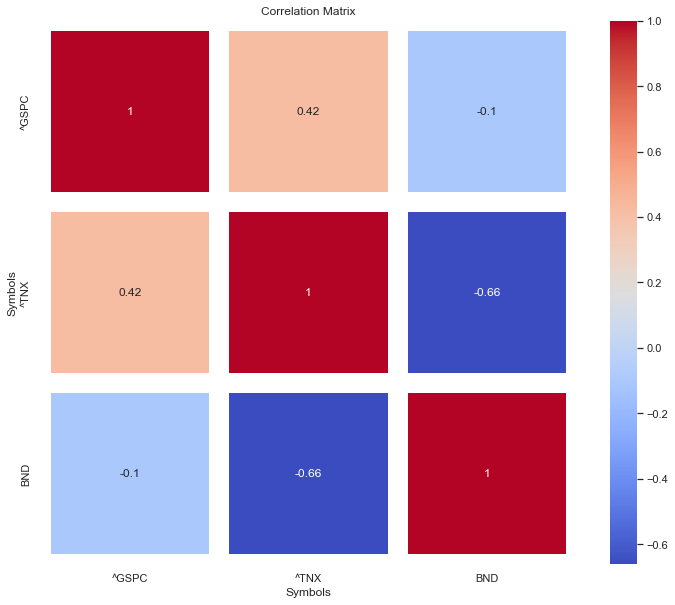

In [21]:
#Display de correlation matrix of portfolio 1
!pip install seaborn 
import seaborn as sns
correlation = logReturns.corr()

sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(correlation, cmap="coolwarm", linewidths=20, annot=True).set(title= "Correlation Matrix")

In [22]:
assetReturns.describe()

Symbols,^GSPC,^TNX,BND
count,3025.000000,3025.000000,3025.000000
mean,1.000531,1.000185,1.000024
std,0.010814,0.030294,0.002664
min,0.880159,0.706799,0.945615
25%,0.996502,0.986158,0.998729
50%,1.000703,0.999189,1.000124
75%,1.005404,1.013245,1.001401
max,1.093828,1.498998,1.042201


In [23]:
#Creating random portfolios

#- How many broad assest classes to include in each portfolio
n_assets = 3

#-- How many portfolios to generate
n_portfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
Tweight = np.zeros((n_portfolios,n_assets))
expectedReturns = np.zeros(n_portfolios)
expectedVolatility = np.zeros(n_portfolios)
sharpeRatio = np.zeros(n_portfolios)

#Calculating Mean and Covariance
meanlogReturn = logReturns.mean()
sigma = logReturns.cov()

np.random.seed(100)
#-- Loop through and generate lots of random portfolios

for k in range(n_portfolios):
    
    #- Choose weights randomly
    Tweights = np.array(np.random.random(n_assets))
    #- Ensure weights sum to 1
    Tweights = Tweights/np.sum(Tweights)
    Tweight[k,:]=Tweights
    
    #expected Returns
    expectedReturns[k] = np.sum(meanlogReturn * Tweights)
    
    #expected volatility
    expectedVolatility[k] = np.sqrt(np.dot(Tweights.T,np.dot(sigma,Tweights)))
    
    #Sharpe Ratio
    sharpeRatio[k] = (expectedReturns[k]/expectedVolatility[k])*np.sqrt(252)

#sharpeRatio
#expectedVolatility
#expectedReturns
#weight

In [24]:
maxIndex = sharpeRatio.argmax()
Tweight[maxIndex,:]

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data1 = (Tweight[maxIndex,:]*100)
Opt_allocation_m1=pd.DataFrame(columns =('Growth', 'Safety','Fixed Income'))
Opt_allocation_m1.loc['Random Weights'] = data1.tolist()
Opt_allocation_m1

,Growth,Safety,Fixed Income
Random Weights,46.92,0.02,53.05


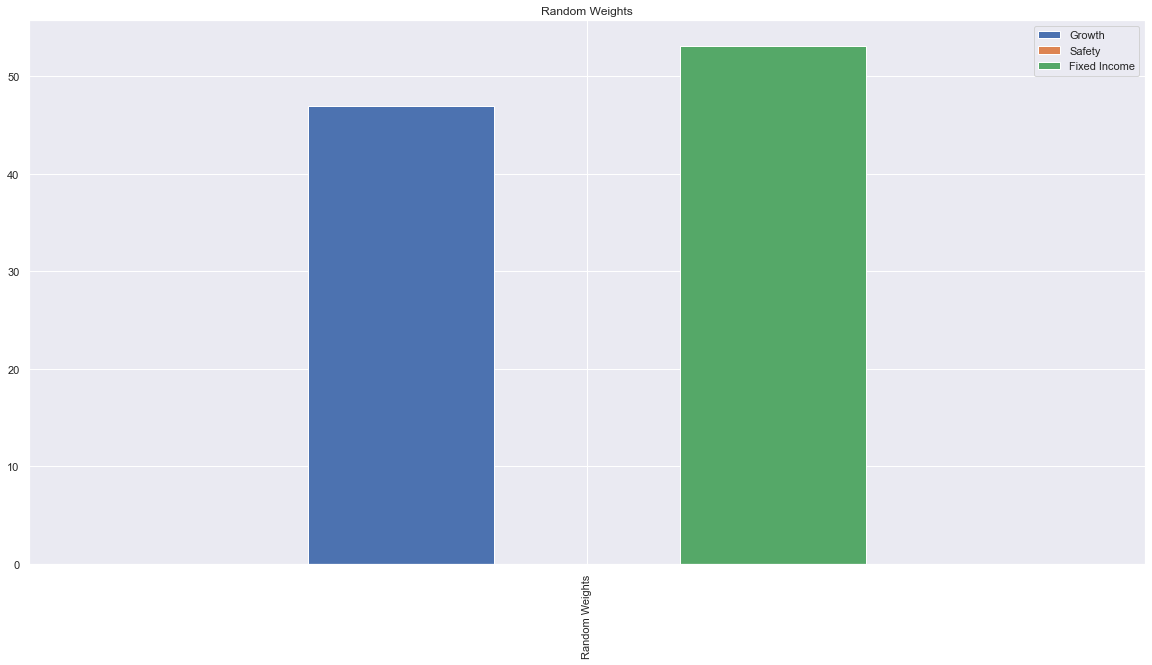

In [27]:

random_weights = Opt_allocation_m1.plot(kind ="bar", title = "Random Weights", figsize=(20, 10))

array([<AxesSubplot:ylabel='Random Weights'>], dtype=object)

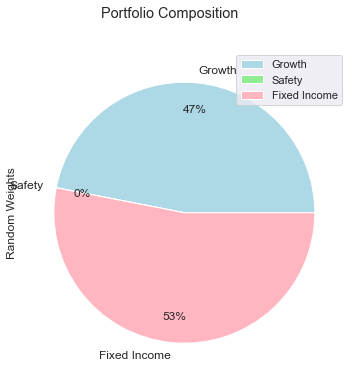

In [25]:
pie_plot_allocation(dataset=Opt_allocation_m1.T) 

In [28]:
#Efficient Frontier
from scipy.optimize import minimize

def negativeSR(Tweights):
    w = np.array(Tweights)
    r = np.sum(meanlogReturn*Tweights)
    v = np.sqrt(np.dot(Tweights.T,np.dot(sigma,Tweights)) )
    SR = r/v
    
    return -1*SR

def checkSumToOne(Tweights):
    return np.sum(Tweights)-1
    
w0 = [0.33,0.33,0.34]
bounds = ((0,1),(0,1),(0,1))
constraints = ({'type':'eq','fun':checkSumToOne})
w_opt = minimize(negativeSR,w0,method='SLSQP',bounds=bounds,constraints=constraints)
#w_opt.x

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data2 = w_opt.x*100
Opt_allocation_m2=pd.DataFrame(columns =('Growth', 'Safety','Fixed Income'))
Opt_allocation_m2.loc['Scipy Optimizer'] = data2.tolist()
Opt_allocation_m2


,Growth,Safety,Fixed Income
Scipy Optimizer,47.93,0.00,52.07


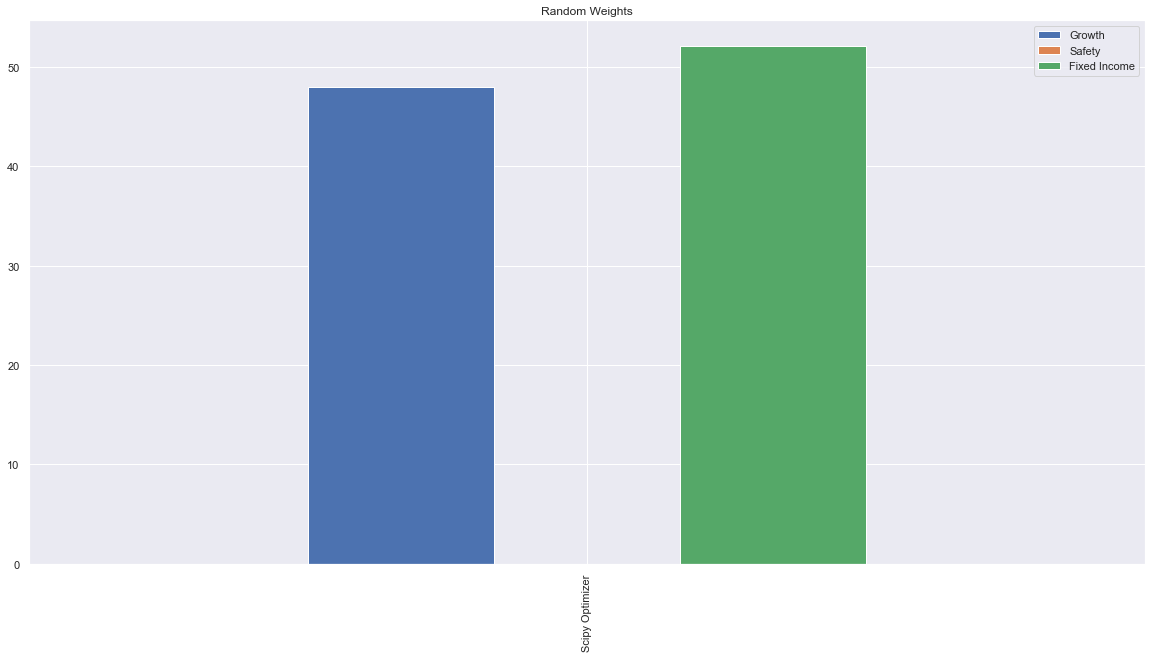

In [29]:
Scipy_optimizer = Opt_allocation_m2.plot(kind ="bar", title = "Random Weights", figsize=(20, 10))

array([<AxesSubplot:ylabel='Scipy Optimizer'>], dtype=object)

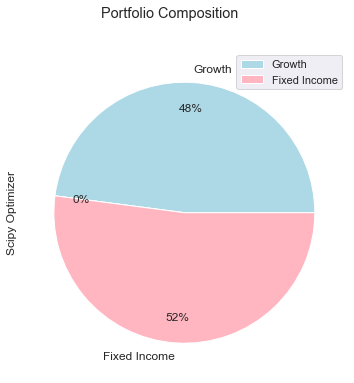

In [30]:
pie_plot_allocation(dataset=Opt_allocation_m2.T) 

In [31]:
# Holding bounds for max and min returns for line plot
upl = expectedReturns.max()
lowl = expectedReturns.min()

#Creating equal parts between upper and lower bins
returns = np.linspace(upl,lowl,50)
volatility_opt = []

def minimizemyVolatility(Tweights):
    w = np.array(Tweights)
    v = np.sqrt(np.dot(Tweights.T,np.dot(sigma,Tweights)) )
    return v

def getReturn(Tweights):
    w = np.array(Tweights)
    R = np.sum(meanlogReturn*Tweights)
    return R

for R in returns:
    #find best volatility
    constraints = ({'type':'eq','fun':checkSumToOne},
                   {'type':'eq','fun':lambda Tweights: getReturn(Tweights)-R})
    opt = minimize(minimizemyVolatility,w0,method='SLSQP',bounds=bounds,constraints=constraints)
    
    #save optimal volatility
    volatility_opt.append(opt['fun'])

#volatility_opt

/Users/khalidromain/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  import sys


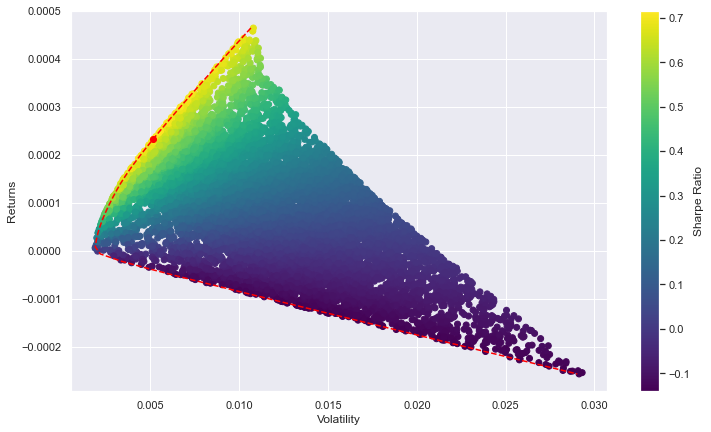

In [36]:
!pip install matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.ylabel('Returns')
plt.xlabel('Volatility')
plt.scatter(expectedVolatility,expectedReturns,c=sharpeRatio,cmap='viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(expectedVolatility[maxIndex],expectedReturns[maxIndex],c='red')
plt.plot(volatility_opt,returns,'--',c='red')
plt.show()



In [37]:
### Optimum Portfolio

pd.options.display.float_format = '{:,.2f}'.format
data0 = np.array([0.000001,0.00001])
data1 = (Tweight[maxIndex,:])
data2 = w_opt.x
Opt_allocation=pd.DataFrame(columns =('Growth', 'Safety','Fixed Income'))
Opt_allocation.loc['Random Weights(W1)'] = data1.tolist()
Opt_allocation.loc['Optimizer Weights(W2)'] = data2.tolist()
Opt_allocation["CCIX"] = data0
Opt_allocation_plot = Opt_allocation.transpose()
Opt_allocation_plot = Opt_allocation_plot+0.000001

array([<AxesSubplot:ylabel='Random Weights(W1)'>,
       <AxesSubplot:ylabel='Optimizer Weights(W2)'>], dtype=object)

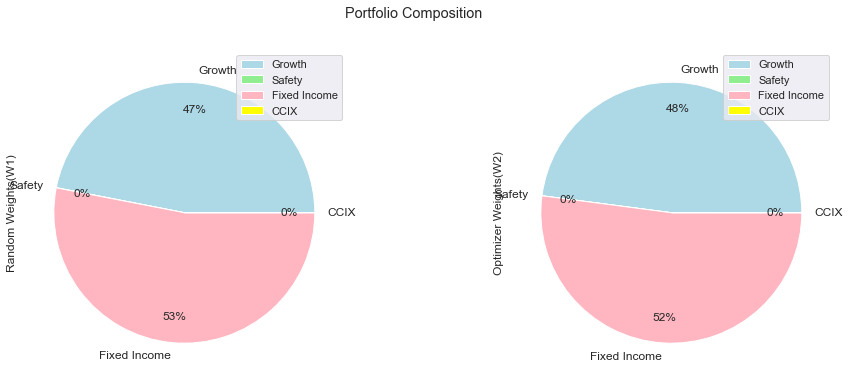

In [38]:
pie_plot_allocation(dataset=Opt_allocation_plot)

In [39]:
#Import data using pandas_datareader
#Import Popular Crypto Data

cryptoList = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'DOT-USD', 'SOL-USD', 'ADA-USD','DOGE-USD','XRP-USD']
endDate = dt.datetime.now()
#endDate = '2021-01-22'
startDate = '2010-01-01'

cryptoData = pdr.DataReader(cryptoList, 'yahoo', startDate, endDate)
cryptoData = cryptoData['Close']
cryptoData.dropna(inplace=True)

cryptoData.head(-1)

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,
2020-08-20,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29
2020-08-21,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28
2020-08-22,"11,681.83",395.84,22.24,4.48,3.02,0.13,0.00,0.29
2020-08-23,"11,664.85",391.38,21.87,3.97,3.32,0.12,0.00,0.29
2020-08-24,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29
...,...,...,...,...,...,...,...,...
2021-12-31,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83
2022-01-01,"47,686.81","3,769.70",527.35,28.58,178.52,1.38,0.17,0.85
2022-01-02,"47,345.22","3,829.56",531.40,29.73,176.38,1.38,0.17,0.86


In [40]:
#computing daily returns on the dataset
cryptoReturns = cryptoData/cryptoData.shift(1)
#cleaning Data
cryptoReturns.dropna(inplace=True)
cryptoReturns

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,
2020-08-21,0.98,0.93,0.96,0.99,0.92,0.93,0.98,0.96
2020-08-22,1.01,1.02,1.01,1.56,1.03,1.01,1.01,1.02
2020-08-23,1.00,0.99,0.98,0.88,1.10,0.97,0.99,1.00
2020-08-24,1.01,1.04,1.03,1.16,1.01,1.02,1.00,1.01
2020-08-25,0.97,0.94,0.95,1.20,0.98,0.91,0.97,0.96
...,...,...,...,...,...,...,...,...
2022-01-01,1.03,1.02,1.03,1.07,1.05,1.05,1.01,1.02
2022-01-02,0.99,1.02,1.01,1.04,0.99,1.00,1.01,1.01
2022-01-03,0.98,0.98,0.96,1.01,0.97,0.96,0.98,0.97


In [41]:
cryptologReturns = np.log(cryptoReturns)
#Cleaning data
cryptologReturns.dropna(inplace=True)

cryptologReturns

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,
2020-08-21,-0.02,-0.07,-0.04,-0.01,-0.09,-0.08,-0.02,-0.04
2020-08-22,0.01,0.02,0.00,0.44,0.03,0.01,0.01,0.02
2020-08-23,-0.00,-0.01,-0.02,-0.12,0.10,-0.03,-0.01,-0.00
2020-08-24,0.01,0.04,0.03,0.15,0.01,0.02,0.00,0.01
2020-08-25,-0.04,-0.06,-0.05,0.18,-0.02,-0.09,-0.03,-0.04
...,...,...,...,...,...,...,...,...
2022-01-01,0.03,0.02,0.03,0.07,0.05,0.05,0.01,0.02
2022-01-02,-0.01,0.02,0.01,0.04,-0.01,0.00,0.01,0.01
2022-01-03,-0.02,-0.02,-0.04,0.01,-0.04,-0.04,-0.03,-0.03


[Text(0.5, 1.0, 'Correlation Matrix')]

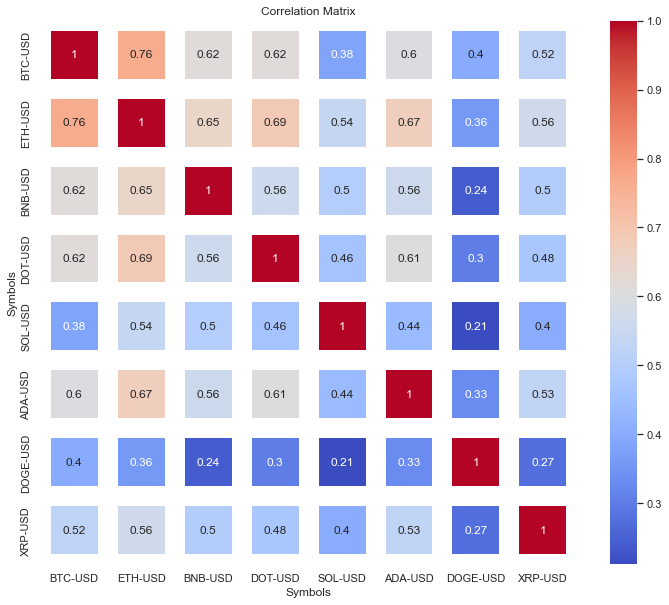

In [90]:

!pip install seaborn 
import seaborn as sns
correlation2 = cryptologReturns.corr()

sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(correlation2, cmap="coolwarm", linewidths=20, annot=True).set(title= "Correlation Matrix")

In [42]:
cryptoReturns.describe()

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
count,503.00,503.00,503.00,503.00,503.00,503.00,503.00,503.00
mean,1.00,1.01,1.01,1.01,1.01,1.01,1.02,1.01
std,0.04,0.05,0.07,0.08,0.09,0.07,0.19,0.08
min,0.86,0.73,0.67,0.62,0.63,0.74,0.60,0.58
25%,0.98,0.98,0.98,0.97,0.96,0.97,0.97,0.97
50%,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00
75%,1.02,1.03,1.03,1.04,1.05,1.03,1.02,1.03
max,1.19,1.26,1.70,1.56,1.47,1.32,4.56,1.56


In [43]:
#Creating random crypto portfolios

#- How many assests to include in each portfolio
n_crypto = 8

#-- How many portfolios to generate
n_Cportfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
Cweight=np.zeros((n_Cportfolios,n_crypto))
CexpectedReturns=np.zeros(n_Cportfolios)
CexpectedVolatility=np.zeros(n_Cportfolios)
CsharpeRatio=np.zeros(n_Cportfolios)

# Computing Mean and Covariance
CmeanlogReturn = cryptologReturns.mean()
Csigma = cryptologReturns.cov()

np.random.seed(100)
#-- Loop through and generate lots of random portfolios
for k in range(n_Cportfolios):
    
    #- Choose weights randomly
    Cweights = np.array(np.random.random(n_crypto))
    #- Ensure weights sum to 1
    Cweights = Cweights/np.sum(Cweights)
    Cweight[k,:]=Cweights
    
    #expected Returns
    CexpectedReturns[k] = np.sum(CmeanlogReturn * Cweights)
    
    #expected volatility
    CexpectedVolatility[k] = np.sqrt(np.dot(Cweights.T,np.dot(Csigma,Cweights)))
    
    #Sharpe Ratio
    CsharpeRatio[k] = (CexpectedReturns[k]/CexpectedVolatility[k])*np.sqrt(365)
    
#Cweight 
#CexpectedReturns
#CexpectedVolatility
#CsharpeRatio

In [44]:
CmaxIndex = CsharpeRatio.argmax()
Cweight[CmaxIndex,:]

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data3 = (Cweight[CmaxIndex,:]*100)
cryp_index_m1=pd.DataFrame(columns = ('Bitcoin','Ethereum',
                                   'Binance','Polkadot',
                                   'Solana','Cardano',
                                   'Dogecoin','Ripple'))
cryp_index_m1.loc['Random Weights'] = data3.tolist()
cryp_index_m1

,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Random Weights,8.28,13.03,25.91,1.35,25.29,11.66,13.36,1.13


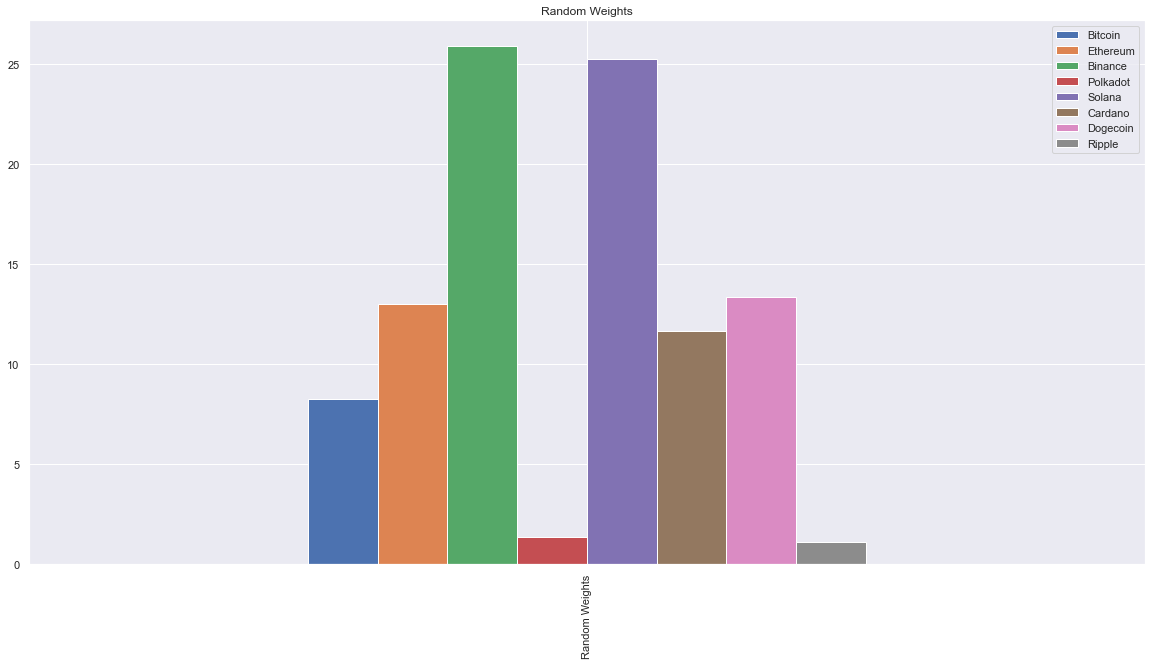

In [45]:
crypto_weights = cryp_index_m1.plot(kind ="bar", title = "Random Weights", figsize=(20, 10))


array([<AxesSubplot:ylabel='Random Weights'>], dtype=object)

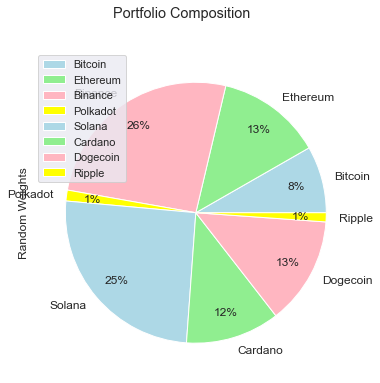

In [46]:
pie_plot_allocation(dataset=cryp_index_m1.T) 

In [47]:
#Efficient Frontier
from scipy.optimize import minimize

def CnegativeSR(Cweights):
    Cw = np.array(Cweights)
    Cr = np.sum(CmeanlogReturn*Cweights)
    Cv = np.sqrt(np.dot(Cweights.T,np.dot(Csigma,Cweights)) )
    CSR = Cr/Cv
    
    return -1*CSR

def CcheckSumToOne(Cweights):
    return np.sum(Cweights)-1
    
Cw0 = [0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125]
Cbounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
Cconstraints = ({'type':'eq','fun':CcheckSumToOne})
Cw_opt = minimize(CnegativeSR,Cw0,method='SLSQP',bounds=Cbounds,constraints=Cconstraints)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
Cw_opt.x*100

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data4 = Cw_opt.x*100
cryp_index_m2=pd.DataFrame(columns = ('Bitcoin','Ethereum',
                                   'Binance','Polkadot',
                                   'Solana','Cardano',
                                   'Dogecoin','Ripple'))
cryp_index_m2.loc['Scipy Optimizer'] = data4.tolist()
cryp_index_m2

,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Scipy Optimizer,0.00,0.00,41.81,0.00,33.48,5.46,19.25,0.00


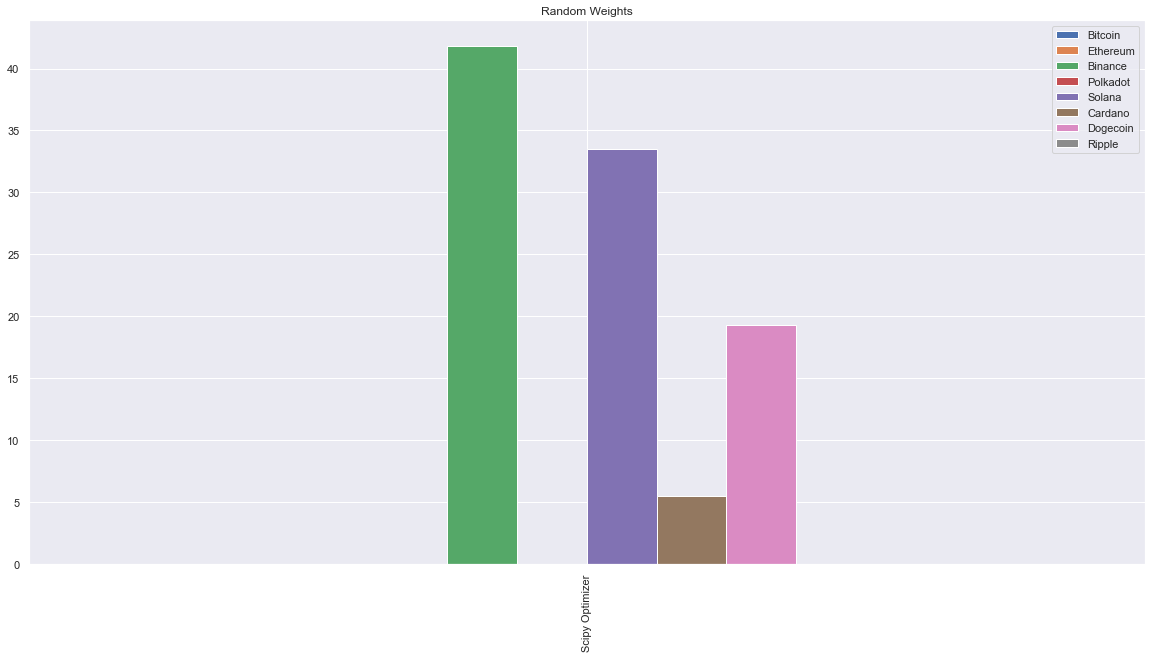

In [48]:
crypto_weights_scipy = cryp_index_m2.plot(kind ="bar", title = "Random Weights", figsize=(20, 10))

array([<AxesSubplot:ylabel='Scipy Optimizer'>], dtype=object)

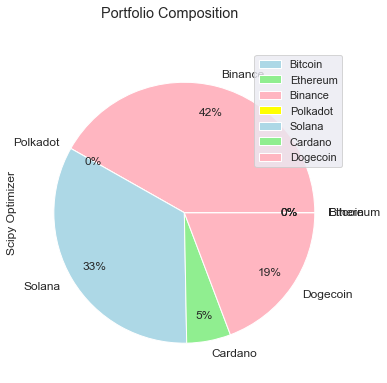

In [49]:
pie_plot_allocation(dataset=cryp_index_m2.T) 

In [50]:
# Holding bounds for max and min returns for line plot
Cupl = CexpectedReturns.max()
Clowl = CexpectedReturns.min()

#Creating equal parts between upper and lower bins
Creturns = np.linspace(Clowl,Cupl,50)
Cvolatility_opt = []

def CminimizemyVolatility(Cweights):
    Cw = np.array(Cweights)
    Cv = np.sqrt(np.dot(Cweights.T,np.dot(Csigma,Cweights)) )
    return Cv

def CgetReturn(Cweights):
    Cw = np.array(Cweights)
    CR = np.sum(CmeanlogReturn*Cweights)
    return CR

for R in Creturns:
    #find best volatility
    Cconstraints = ({'type':'eq','fun':CcheckSumToOne},
                   {'type':'eq','fun':lambda Cweights: CgetReturn(Cweights)-R})
    Copt = minimize(CminimizemyVolatility,Cw0,method='SLSQP',bounds=Cbounds,constraints=Cconstraints)
    
    #save optimal volatility
    Cvolatility_opt.append(Copt['fun'])
#Cvolatility_opt

/Users/khalidromain/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


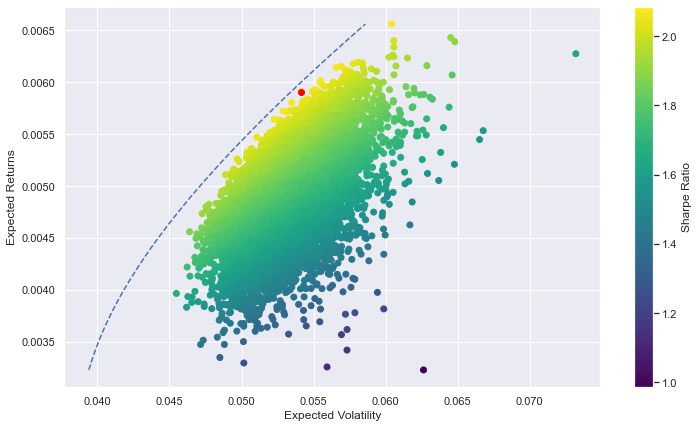

In [51]:
plt.figure(figsize=(12,7))
plt.ylabel('Expected Returns')
plt.xlabel('Expected Volatility')
plt.scatter(CexpectedVolatility,CexpectedReturns,c=CsharpeRatio,cmap='viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(CexpectedVolatility[CmaxIndex],CexpectedReturns[CmaxIndex],c='red')
plt.plot(Cvolatility_opt,Creturns,'--')
plt.show()

In [52]:
#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data3 = (Cweight[CmaxIndex,:])
data4 = Cw_opt.x
cryp_index=pd.DataFrame(columns = ('Bitcoin','Ethereum',
                                   'Binance','Polkadot',
                                   'Solana','Cardano',
                                   'Dogecoin','Ripple'))
cryp_index.loc['Random Weights'] = data3.tolist()
cryp_index.loc['Optimizer Weights'] = data4.tolist()
cryp_index_plot = cryp_index.transpose()
cryp_index_plot

,Random Weights,Optimizer Weights
Bitcoin,0.08,0.00
Ethereum,0.13,0.00
Binance,0.26,0.42
Polkadot,0.01,0.00
Solana,0.25,0.33
Cardano,0.12,0.05
Dogecoin,0.13,0.19
Ripple,0.01,0.00


array([<AxesSubplot:ylabel='Random Weights'>,
       <AxesSubplot:ylabel='Optimizer Weights'>], dtype=object)

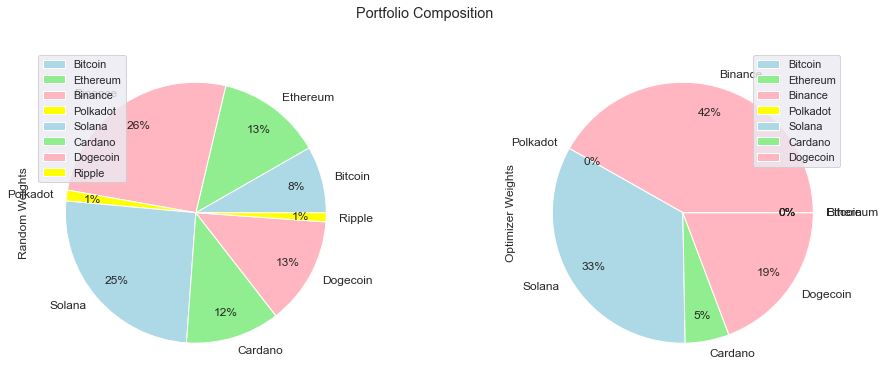

In [53]:
pie_plot_allocation(dataset=cryp_index.T) 

In [54]:
combined_data = pd.concat([assetData,cryptoData],axis=1,
    join="inner")
combined_data

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,,,,
2020-08-20,"3,385.51",0.64,88.58,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29
2020-08-21,"3,397.16",0.64,88.77,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28
2020-08-24,"3,431.28",0.65,88.67,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29
2020-08-25,"3,443.62",0.68,88.50,"11,366.13",384.00,21.48,5.52,3.26,0.11,0.00,0.28
2020-08-26,"3,478.73",0.69,88.45,"11,488.36",386.47,22.28,6.08,3.56,0.12,0.00,0.28
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"46,444.71","3,628.53",514.00,26.74,170.66,1.33,0.17,0.82
2021-12-30,"4,778.73",1.51,84.77,"47,178.12","3,713.85",518.91,27.57,172.75,1.36,0.17,0.84
2021-12-31,"4,766.18",1.51,84.75,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83


In [55]:
#computing daily returns on the dataset
combined_returns = combined_data/combined_data.shift(1)
#cleaning Data
combined_returns.dropna(inplace=True)
combined_returns

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,,,,
2020-08-21,1.00,0.99,1.00,0.98,0.93,0.96,0.99,0.92,0.93,0.98,0.96
2020-08-24,1.01,1.01,1.00,1.02,1.05,1.02,1.60,1.14,1.01,1.01,1.03
2020-08-25,1.00,1.06,1.00,0.97,0.94,0.95,1.20,0.98,0.91,0.97,0.96
2020-08-26,1.01,1.01,1.00,1.01,1.01,1.04,1.10,1.09,1.02,1.00,1.00
2020-08-27,1.00,1.09,1.00,0.99,0.99,1.04,0.93,0.97,0.93,0.97,0.95
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,1.00,1.04,1.00,0.98,0.95,0.96,0.96,0.96,0.95,0.96,0.96
2021-12-30,1.00,0.98,1.00,1.02,1.02,1.01,1.03,1.01,1.02,1.02,1.03
2021-12-31,1.00,1.00,1.00,0.98,0.99,0.99,0.97,0.99,0.96,1.00,0.99


In [56]:
cryp_index

,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Random Weights,0.08,0.13,0.26,0.01,0.25,0.12,0.13,0.01
Optimizer Weights,0.00,0.00,0.42,0.00,0.33,0.05,0.19,0.00


In [57]:
CCIX_val = ((combined_data['BTC-USD']*cryp_index['Bitcoin'].loc["Random Weights"])+
            (combined_data['ETH-USD']*cryp_index['Ethereum'].loc["Random Weights"])+
            (combined_data['BNB-USD']*cryp_index['Binance'].loc["Random Weights"])+
            (combined_data['DOT-USD']*cryp_index['Polkadot'].loc["Random Weights"])+
            (combined_data['SOL-USD']*cryp_index['Solana'].loc["Random Weights"])+
            (combined_data['ADA-USD']*cryp_index['Cardano'].loc["Random Weights"])+
            (combined_data['DOGE-USD']*cryp_index['Dogecoin'].loc["Random Weights"])+
            (combined_data['XRP-USD']*cryp_index['Ripple'].loc["Random Weights"]))

In [58]:
combined_data["CCIX"] = CCIX_val
combined_data

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD,CCIX
Date,,,,,,,,,,,,
2020-08-20,"3,385.51",0.64,88.58,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29,"1,044.86"
2020-08-21,"3,397.16",0.64,88.77,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28,"1,017.30"
2020-08-24,"3,431.28",0.65,88.67,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29,"1,035.11"
2020-08-25,"3,443.62",0.68,88.50,"11,366.13",384.00,21.48,5.52,3.26,0.11,0.00,0.28,997.84
2020-08-26,"3,478.73",0.69,88.45,"11,488.36",386.47,22.28,6.08,3.56,0.12,0.00,0.28,"1,008.57"
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"46,444.71","3,628.53",514.00,26.74,170.66,1.33,0.17,0.82,"4,496.06"
2021-12-30,"4,778.73",1.51,84.77,"47,178.12","3,713.85",518.91,27.57,172.75,1.36,0.17,0.84,"4,569.73"
2021-12-31,"4,766.18",1.51,84.75,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83,"4,490.97"


In [59]:
CCIX_WG = ((combined_returns['BTC-USD']*cryp_index['Bitcoin'].loc["Random Weights"])+
            (combined_returns['ETH-USD']*cryp_index['Ethereum'].loc["Random Weights"])+
            (combined_returns['BNB-USD']*cryp_index['Binance'].loc["Random Weights"])+
            (combined_returns['DOT-USD']*cryp_index['Polkadot'].loc["Random Weights"])+
            (combined_returns['SOL-USD']*cryp_index['Solana'].loc["Random Weights"])+
            (combined_returns['ADA-USD']*cryp_index['Cardano'].loc["Random Weights"])+
            (combined_returns['DOGE-USD']*cryp_index['Dogecoin'].loc["Random Weights"])+
            (combined_returns['XRP-USD']*cryp_index['Ripple'].loc["Random Weights"]))

In [60]:
combined_returns["CCIX"] = CCIX_WG
combined_returns

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD,CCIX
Date,,,,,,,,,,,,
2020-08-21,1.00,0.99,1.00,0.98,0.93,0.96,0.99,0.92,0.93,0.98,0.96,0.95
2020-08-24,1.01,1.01,1.00,1.02,1.05,1.02,1.60,1.14,1.01,1.01,1.03,1.06
2020-08-25,1.00,1.06,1.00,0.97,0.94,0.95,1.20,0.98,0.91,0.97,0.96,0.96
2020-08-26,1.01,1.01,1.00,1.01,1.01,1.04,1.10,1.09,1.02,1.00,1.00,1.04
2020-08-27,1.00,1.09,1.00,0.99,0.99,1.04,0.93,0.97,0.93,0.97,0.95,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,1.00,1.04,1.00,0.98,0.95,0.96,0.96,0.96,0.95,0.96,0.96,0.96
2021-12-30,1.00,0.98,1.00,1.02,1.02,1.01,1.03,1.01,1.02,1.02,1.03,1.02
2021-12-31,1.00,1.00,1.00,0.98,0.99,0.99,0.97,0.99,0.96,1.00,0.99,0.98


In [61]:
#New Combined Data with Price/Values
new_combinedData = combined_data.drop(["BTC-USD","ETH-USD","BNB-USD","DOT-USD","SOL-USD","ADA-USD","DOGE-USD","XRP-USD"],axis=1)
new_combinedData

Symbols,^GSPC,^TNX,BND,CCIX
Date,,,,
2020-08-20,"3,385.51",0.64,88.58,"1,044.86"
2020-08-21,"3,397.16",0.64,88.77,"1,017.30"
2020-08-24,"3,431.28",0.65,88.67,"1,035.11"
2020-08-25,"3,443.62",0.68,88.50,997.84
2020-08-26,"3,478.73",0.69,88.45,"1,008.57"
...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"4,496.06"
2021-12-30,"4,778.73",1.51,84.77,"4,569.73"
2021-12-31,"4,766.18",1.51,84.75,"4,490.97"


In [62]:
#New Combined Data with Returns
new_combinedReturns = combined_returns.drop(["BTC-USD","ETH-USD","BNB-USD","DOT-USD","SOL-USD","ADA-USD","DOGE-USD","XRP-USD"],axis=1)
new_combinedReturns

Symbols,^GSPC,^TNX,BND,CCIX
Date,,,,
2020-08-21,1.00,0.99,1.00,0.95
2020-08-24,1.01,1.01,1.00,1.06
2020-08-25,1.00,1.06,1.00,0.96
2020-08-26,1.01,1.01,1.00,1.04
2020-08-27,1.00,1.09,1.00,0.98
...,...,...,...,...
2021-12-29,1.00,1.04,1.00,0.96
2021-12-30,1.00,0.98,1.00,1.02
2021-12-31,1.00,1.00,1.00,0.98


In [63]:
new_combinedReturns.describe()

Symbols,^GSPC,^TNX,BND,CCIX
count,346.00,346.00,346.00,346.00
mean,1.00,1.00,1.00,1.01
std,0.01,0.03,0.00,0.07
min,0.96,0.87,0.99,0.69
25%,1.00,0.98,1.00,0.97
50%,1.00,1.00,1.00,1.01
75%,1.01,1.02,1.00,1.04
max,1.02,1.17,1.01,1.52


In [64]:
new_logcombinedReturns = np.log(new_combinedReturns)
#Cleaning data
new_logcombinedReturns.dropna(inplace=True)

new_logcombinedReturns

Symbols,^GSPC,^TNX,BND,CCIX
Date,,,,
2020-08-21,0.00,-0.01,0.00,-0.06
2020-08-24,0.01,0.01,-0.00,0.06
2020-08-25,0.00,0.05,-0.00,-0.04
2020-08-26,0.01,0.01,-0.00,0.04
2020-08-27,0.00,0.08,-0.00,-0.02
...,...,...,...,...
2021-12-29,0.00,0.04,-0.00,-0.04
2021-12-30,-0.00,-0.02,0.00,0.02
2021-12-31,-0.00,-0.00,-0.00,-0.02


[Text(0.5, 1.0, 'Correlation Matrix')]

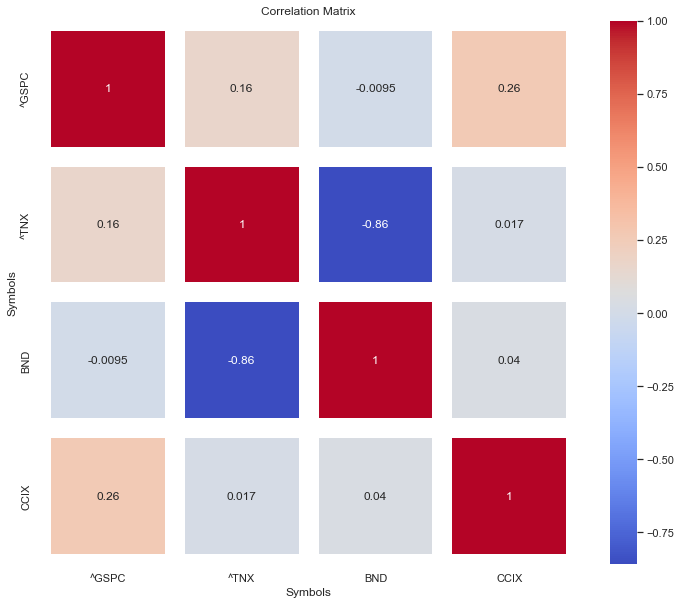

In [93]:

!pip install seaborn 
import seaborn as sns
correlation3 = new_logcombinedReturns.corr()

sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(correlation3, cmap="coolwarm", linewidths=20, annot=True).set(title= "Correlation Matrix")

In [82]:
!pip install hvplot
import hvplot.pandas
new_logcombinedReturns.hvplot.line(title='Log Returns',)

:NdOverlay   [Symbols]
   :Curve   [Date]   (value)

In [83]:
#Creating random crypto portfolios

#- How many assests to include in each portfolio
n_TC = 4

#-- How many portfolios to generate
n_TCportfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
TCweight=np.zeros((n_TCportfolios,n_TC))
TCexpectedReturns=np.zeros(n_TCportfolios)
TCexpectedVolatility=np.zeros(n_TCportfolios)
TCsharpeRatio=np.zeros(n_TCportfolios)

# Computing Mean and Covariance
TCmeanlogReturn = new_logcombinedReturns.mean()
TCsigma = new_logcombinedReturns.cov()

np.random.seed(100)
#-- Loop through and generate lots of random portfolios
for k in range(n_TCportfolios):
    
    #- Choose weights randomly
    TCweights = np.array(np.random.random(n_TC))
    #- Ensure weights sum to 1
    TCweights = TCweights/np.sum(TCweights)
    TCweight[k,:]=TCweights
    
    #expected Returns
    TCexpectedReturns[k] = np.sum(TCmeanlogReturn * TCweights)
    
    #expected volatility
    TCexpectedVolatility[k] = np.sqrt(np.dot(TCweights.T,np.dot(TCsigma,TCweights)))
    
    #Sharpe Ratio
    TCsharpeRatio[k] = (TCexpectedReturns[k]/TCexpectedVolatility[k])*np.sqrt(365)
    
#Cweight 
#CexpectedReturns
#CexpectedVolatility
#CsharpeRatio

In [84]:
TCmaxIndex = TCsharpeRatio.argmax()
TCweight[TCmaxIndex,:]*100

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data5 = (TCweight[TCmaxIndex,:]*100)
TC_index_m1=pd.DataFrame(columns = ('S&P 500','T-BILL',
                                   'BOND INDEX','CCIX'))
TC_index_m1.loc['Random Weights'] = data5.tolist()
TC_index_m1

,S&P 500,T-BILL,BOND INDEX,CCIX
Random Weights,59.32,20.63,0.85,19.20


In [85]:
#Efficient Frontier
from scipy.optimize import minimize

def TCnegativeSR(TCweights):
    TCw = np.array(TCweights)
    TCr = np.sum(TCmeanlogReturn*TCweights)
    TCv = np.sqrt(np.dot(TCweights.T,np.dot(TCsigma,TCweights)) )
    TCSR = TCr/TCv
    
    return -1*TCSR

def TCcheckSumToOne(TCweights):
    return np.sum(TCweights)-1
    
TCw0 = [0.25,0.25,0.25,0.25]
TCbounds = ((0,1),(0,1),(0,1),(0,1))
TCconstraints = ({'type':'eq','fun':TCcheckSumToOne})
TCw_opt = minimize(TCnegativeSR,TCw0,method='SLSQP',bounds=TCbounds,constraints=TCconstraints)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
TCw_opt.x*100

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data6 = TCw_opt.x*100
TC_index_m2=pd.DataFrame(columns = ('S&P 500','T-BILL',
                                   'BOND INDEX','CCIX'))
TC_index_m2.loc['Optimizer Weights'] = data6.tolist()
TC_index_m2

,S&P 500,T-BILL,BOND INDEX,CCIX
Optimizer Weights,61.40,18.83,0.00,19.78


In [86]:
# Holding bounds for max and min returns for line plot
TCupl = TCexpectedReturns.max()
TClowl = TCexpectedReturns.min()

#Creating equal parts between upper and lower bins
TCreturns = np.linspace(TCupl,TClowl,50)
TCvolatility_opt = []

def TCminimizemyVolatility(TCweights):
    TCw = np.array(TCweights)
    TCv = np.sqrt(np.dot(TCweights.T,np.dot(TCsigma,TCweights)) )
    return TCv

def TCgetReturn(TCweights):
    TCw = np.array(TCweights)
    TCR = np.sum(TCmeanlogReturn*TCweights)
    return TCR

for R in TCreturns:
    #find best volatility
    TCconstraints = ({'type':'eq','fun':TCcheckSumToOne},
                   {'type':'eq','fun':lambda TCweights: TCgetReturn(TCweights)-R})
    TCopt = minimize(TCminimizemyVolatility,TCw0,method='SLSQP',bounds=TCbounds,constraints=TCconstraints)
    
    #save optimal volatility
    TCvolatility_opt.append(TCopt['fun'])
#TCvolatility_opt

/Users/khalidromain/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


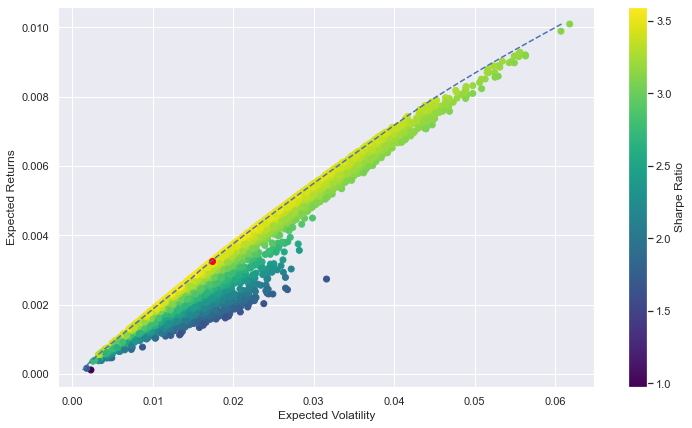

In [87]:
plt.figure(figsize=(12,7))
plt.ylabel('Expected Returns')
plt.xlabel('Expected Volatility')
plt.scatter(TCexpectedVolatility,TCexpectedReturns,c=TCsharpeRatio,cmap='viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(TCexpectedVolatility[TCmaxIndex],TCexpectedReturns[TCmaxIndex],c='red')
plt.plot(TCvolatility_opt,TCreturns,'--')
plt.show()

In [88]:
#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data5 = (TCweight[TCmaxIndex,:])
data6 = TCw_opt.x
TC_index=pd.DataFrame(columns = ('Growth','Safety',
                                   'Fixed Income','CCIX'))
TC_index.loc['Random Weights(W5)'] = data5.tolist()
TC_index.loc['Optimizer Weights(W6)'] = data6.tolist()
TC_index_plot=TC_index.transpose()
TC_index_plot

,Random Weights(W5),Optimizer Weights(W6)
Growth,0.59,0.61
Safety,0.21,0.19
Fixed Income,0.01,0.00
CCIX,0.19,0.20


array([<AxesSubplot:ylabel='Random Weights(W5)'>,
       <AxesSubplot:ylabel='Optimizer Weights(W6)'>], dtype=object)

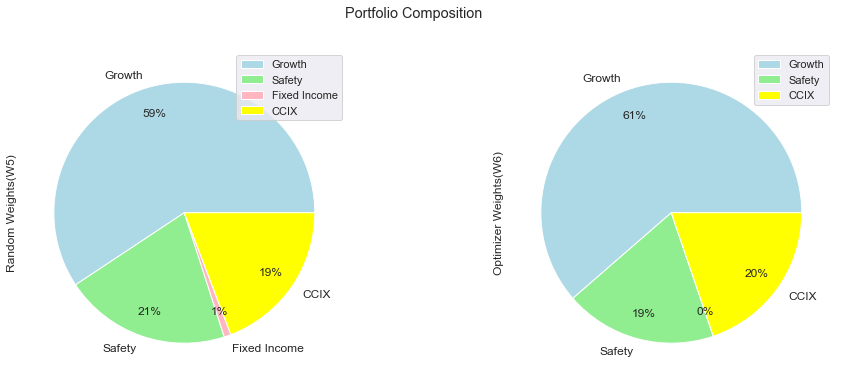

In [89]:
pie_plot_allocation(dataset=TC_index.T) 